## 用户流失预测模型

### 提出问题
1. 哪些用户可能流失？
2. 流失概率更高的的用户是哪些用户？

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from pylab import rcParams

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [139]:
from sklearn.ensemble import RandomForestClassifier          # 随机森林
from sklearn.svm import SVC, LinearSVC                       # 支持向量机
from sklearn.linear_model import LogisticRegression          # 逻辑回归
from sklearn.neighbors import KNeighborsClassifier           # KNN算法
from sklearn.naive_bayes import GaussianNB                   # 朴素贝叶斯
from sklearn.tree import DecisionTreeClassifier              # 决策树分类器
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier     

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import VotingClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
# 读取数据
data = pd.read_csv(r'C:\数据分析\telco-customer-churn\WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 查看数据信息

In [6]:
print ("Rows     : " ,data.shape[0])
print ("Columns  : " ,data.shape[1])
print ("\nFeatures : \n" ,data.columns.tolist())
print ("\nMissing values :  ", data.isnull().sum().values.sum())
print ("\nUnique values :  \n",data.nunique())
print ("\nduplicate values :  \n",data.duplicated().sum())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

duplicate values :  
 0


In [7]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### 数据清洗

In [8]:
# 1. 查找缺失值
pd.isnull(data).sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [17]:
# 2. 查看数据类型
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [19]:
# 3. 数据转换
# 将TotalCharges转化成float类型
# data['TotalCharges'].str.replace(' ',0).astype('float64')  报错
data['TotalCharges'] = data['TotalCharges'].replace(' ',0).astype('float64')

In [21]:
data['Churn'] = data['Churn'].replace({'Yes':1,'No':0})
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


### 数据可视化

In [22]:
# 1. 查看流失客户的占比
churn_value = data['Churn'].value_counts()
labels = data['Churn'].value_counts().index
print(churn_value,labels)

0    5174
1    1869
Name: Churn, dtype: int64 Int64Index([0, 1], dtype='int64')


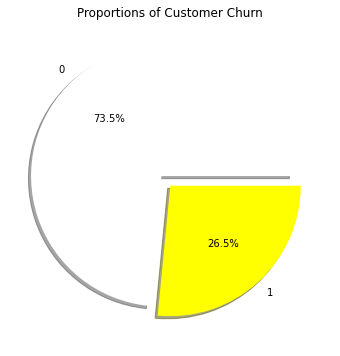

In [29]:
rcParams['figure.figsize']=6,6
plt.pie(churn_value,labels=labels,colors=['white','yellow'],explode=(0.1,0),autopct='%1.1f%%',shadow=True)
plt.title('Proportions of Customer Churn')
plt.show()

Text(0.5, 1.0, 'Churn by Dependents')

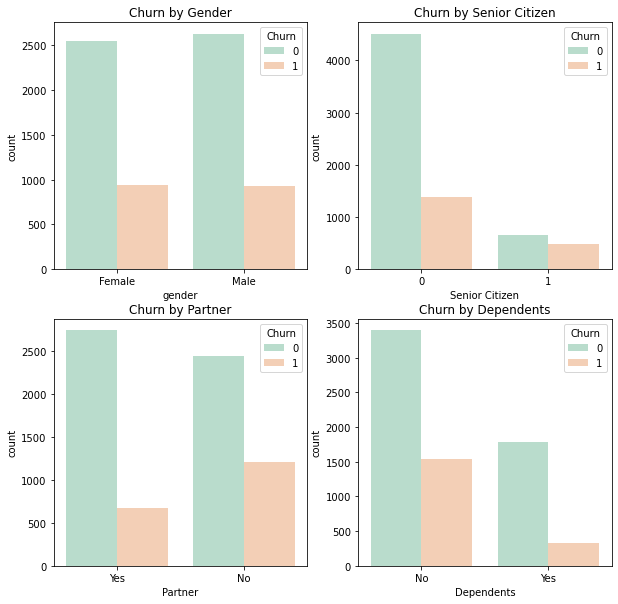

In [33]:
# 2. 性别、老年人、配偶、亲属对客户流失率的影响
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

plt.subplot(2,2,1)
gender = sns.countplot(x='gender',hue='Churn',data=data,palette='Pastel2')
plt.xlabel('gender')
plt.title('Churn by Gender')

plt.subplot(2,2,2)
gender = sns.countplot(x='SeniorCitizen',hue='Churn',data=data,palette='Pastel2')
plt.xlabel('Senior Citizen')
plt.title('Churn by Senior Citizen')

plt.subplot(2,2,3)
gender = sns.countplot(x='Partner',hue='Churn',data=data,palette='Pastel2')
plt.xlabel('Partner')
plt.title('Churn by Partner')

plt.subplot(2,2,4)
gender = sns.countplot(x='Dependents',hue='Churn',data=data,palette='Pastel2')
plt.xlabel('Dependents')
plt.title('Churn by Dependents')

1. 男性与女性用户之间的流失情况基本没有差异；
2. 在老年用户中流失占比明显比非老年用户更高；
3. 未婚与已婚人数基本持平，但未婚中流失人数比已婚中的流失人数高出了快一倍；
4. 经济未独立的用户流失率要远远高于经济独立的用户。

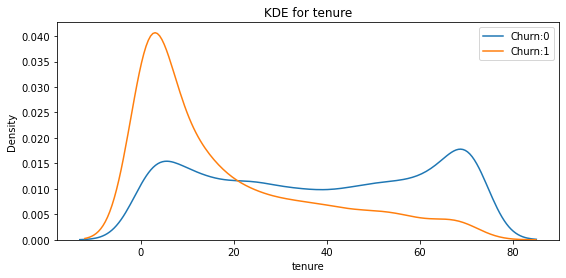

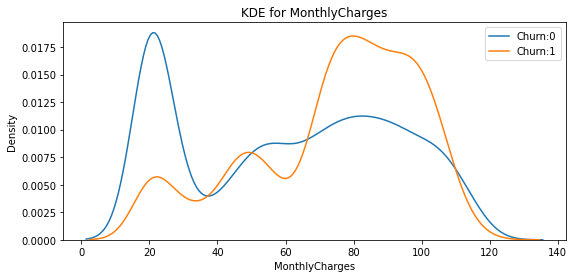

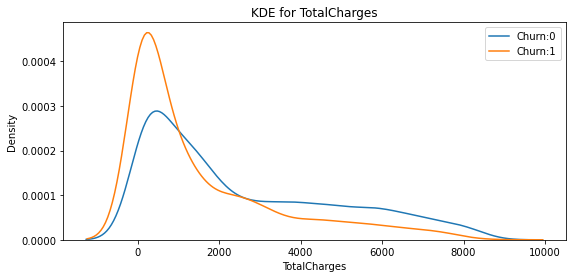

In [40]:
# 3. 客户的职位、月费用、总费用
# kdeplot：核密度估计(kernel density estimation)是在概率论中用来估计未知的密度函数，比较直观的看出数据样本本身的分布特征
def kdeplot(feature):
    plt.figure(figsize=(9,4))
    plt.title('KDE for {}'.format(feature))
    ax0 = sns.kdeplot(data[data.Churn == 0][feature],label = 'Churn:0')
    ax1 = sns.kdeplot(data[data.Churn == 1][feature],label = 'Churn:1')
    plt.legend()

kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

1. 客户职位tennre越低的客户更容易丢失
2. 每月收入越高的客户更容易丢失

In [50]:
# 4. 进一步分析tenure
def tenure_lab(x):
    if x <= 12:
        return '0-12'
    elif (x > 12) & (x <= 24):
        return '12-24'
    elif (x > 24) & (x <= 36):
        return '24-36'
    elif (x > 36) & (x <= 48):
        return '36-48'
    elif (x > 48) & (x <= 60):
        return '48-60'
    elif x > 60:
        return 'gt_60'
data['tenure_group'] = data['tenure'].apply(tenure_lab)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-12
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,24-36
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-12
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,36-48
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-12


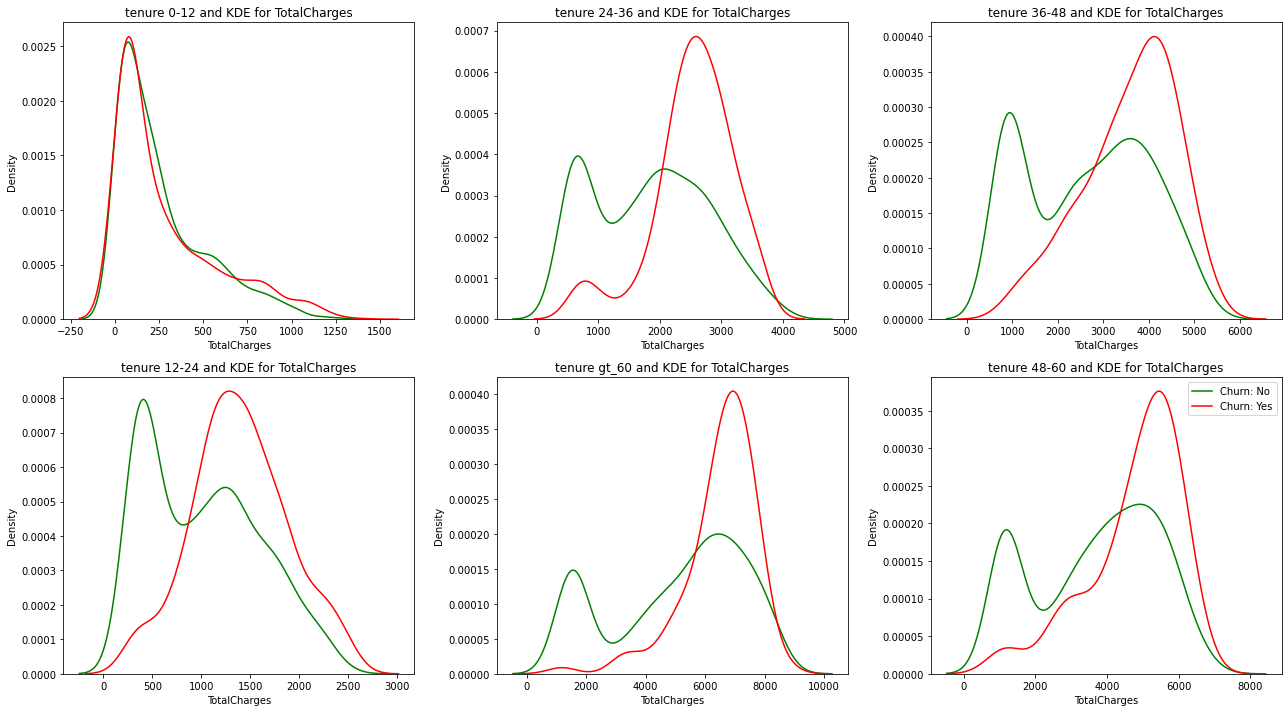

In [60]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 10))
for n,i  in enumerate(data['tenure_group'].unique()):
    df = data[data['tenure_group']==i]
    if n <3 :
        p = 0
    else :
        p = 1
        n-=3
    ax =sns.kdeplot(df[df['Churn'] == 0]['TotalCharges'], label= 'Churn: No',ax=axis[p][n],color="g")
    ax =sns.kdeplot(df[df['Churn'] == 1]['TotalCharges'], label= 'Churn: Yes',ax=axis[p][n],color="r")
    ax.set_title("tenure {} and KDE for TotalCharges".format(i))
    plt.tight_layout()
plt.legend()

tenure越大，TotalCharges越大流失率越大

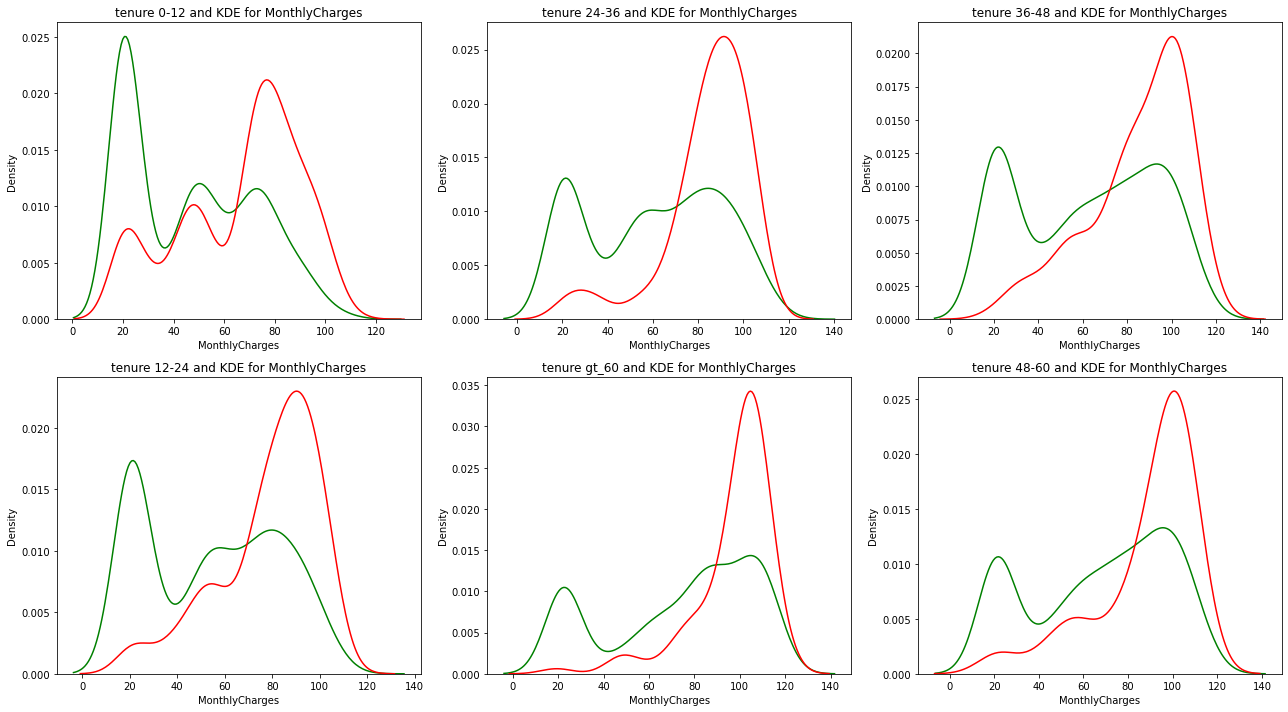

In [59]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 10))
for n,i  in enumerate(data['tenure_group'].unique()):
    df = data[data['tenure_group']==i]
    if n <3 :
        p = 0
    else :
        p = 1
        n-=3
    ax =sns.kdeplot(df[df['Churn'] == 0]['MonthlyCharges'], label= 'Churn: No',ax=axis[p][n],legend=True,color="g")
    ax =sns.kdeplot(df[df['Churn'] == 1]['MonthlyCharges'], label= 'Churn: Yes',ax=axis[p][n],legend=True,color="r")
    ax.set_title("tenure {} and KDE for MonthlyCharges".format(i))
    plt.tight_layout()

无论Tenure如何，Monthly越高流失率越大

### 类别分析
6个二元分类，9个三元分类，1个四元分类

In [61]:
data.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
tenure_group           6
dtype: int64

In [62]:
# 获取二元分类数据的行索引
data.columns[data.nunique() == 2]

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn'],
      dtype='object')

In [63]:
bi_feature = [x for x in data.columns[data.nunique() == 2] if x not in ('Churn')]
bi_feature

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling']

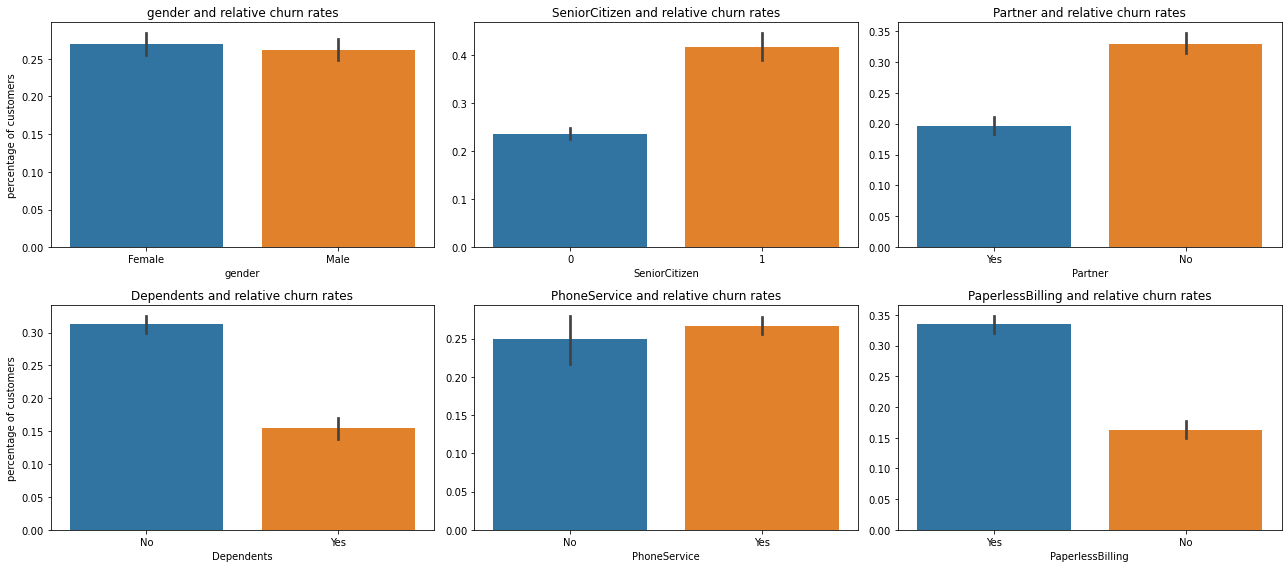

In [71]:
import warnings
warnings.filterwarnings("ignore")
fig,axis = plt.subplots(nrows=2,ncols=3,figsize=(18,8))
for n,i in enumerate(bi_feature):
    if n < 3:
        p = 0
    else:
        p = 1
        n -= 3
    ax = sns.barplot(data[i],data['Churn'],ax=axis[p][n])
    if ((p == 0) & (n == 0))|((p == 1) & (n == 0)) :
        ax.set_ylabel('percentage of customers')
    else:
        ax.set_ylabel('')
    ax.set_title("{} and relative churn rates".format(i))
    plt.tight_layout()

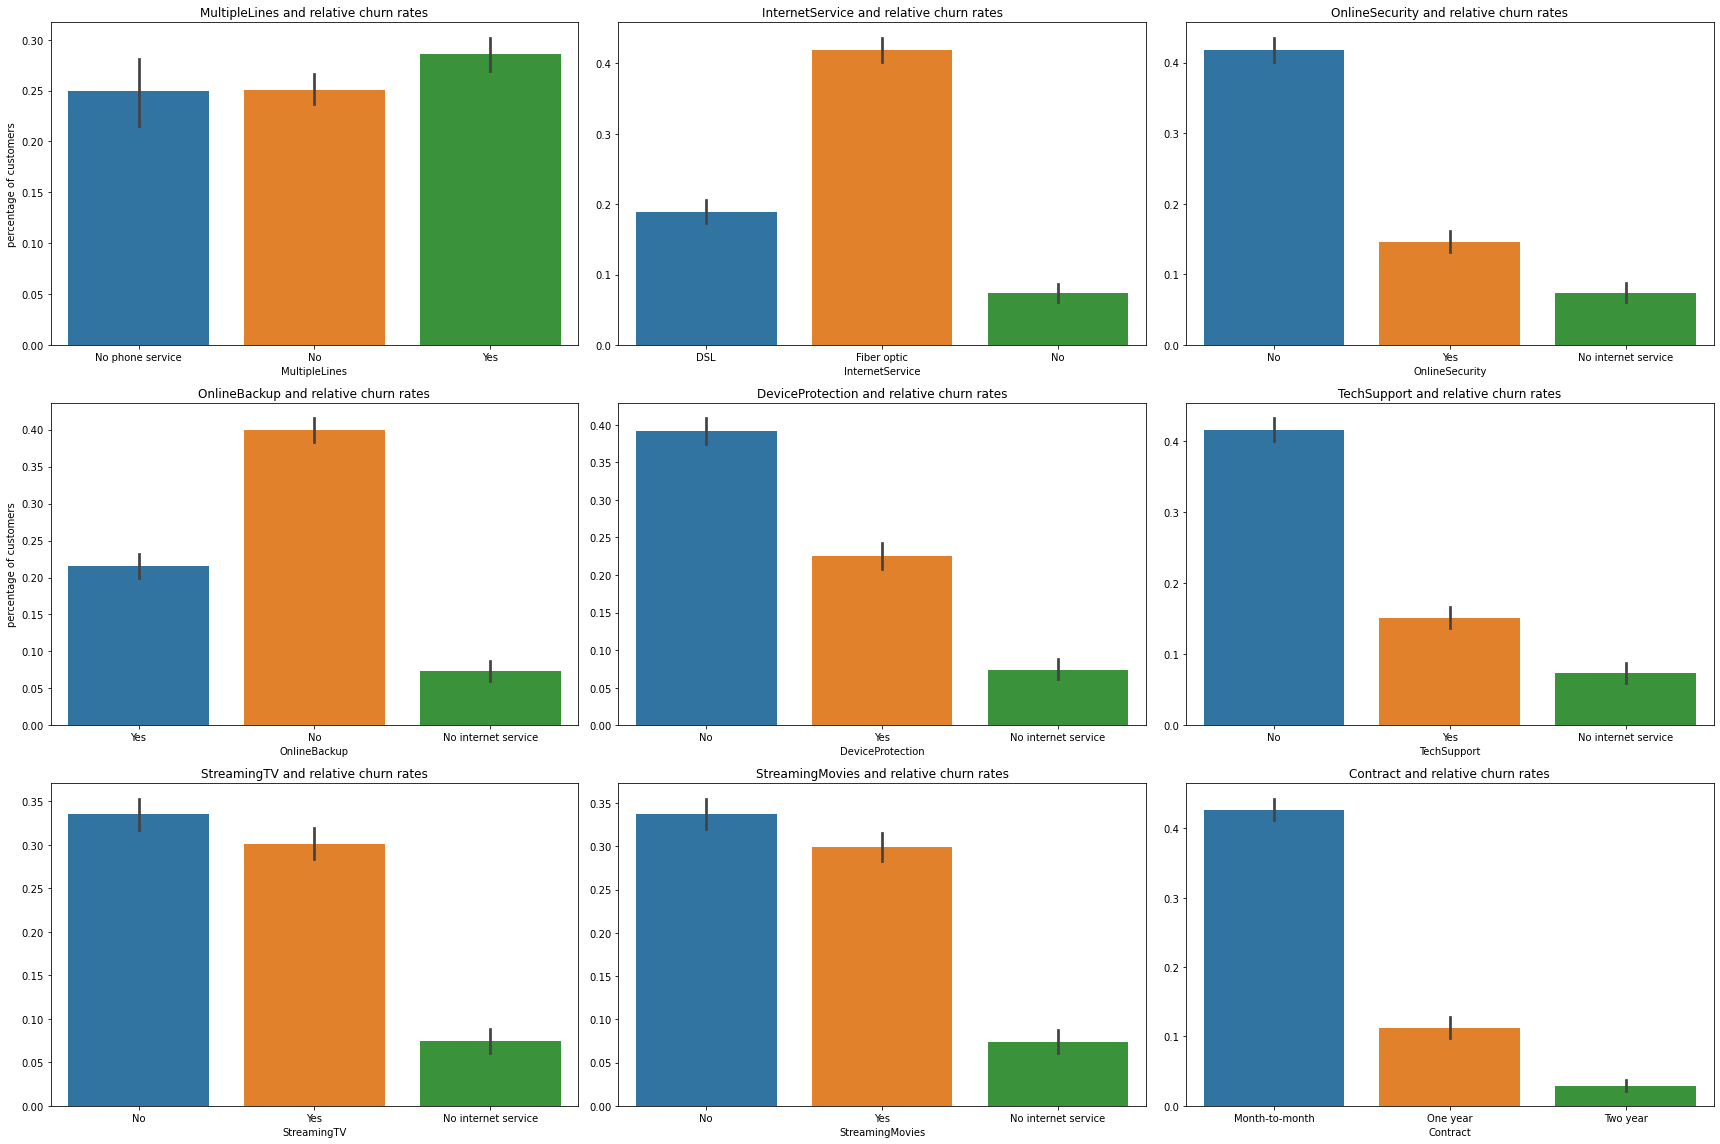

In [76]:
ter_feature = [x for x in data.columns[data.nunique() == 3]]
fig,axis = plt.subplots(nrows=3,ncols=3,figsize=(24,16))
for n,i in enumerate(ter_feature):
    if n < 3:
        p = 0
    elif n < 6:
        p = 1
        n -= 3
    else:
        p = 2
        n -= 6
    ax = sns.barplot(data[i],data['Churn'],ax=axis[p][n])
    if ((p == 0) & (n == 0))|((p == 1) & (n == 0)) :
        ax.set_ylabel('percentage of customers')
    else:
        ax.set_ylabel('')
    ax.set_title("{} and relative churn rates".format(i))
    plt.tight_layout()

Text(0.5, 1.0, 'PaymentMethod and relative churn rates')

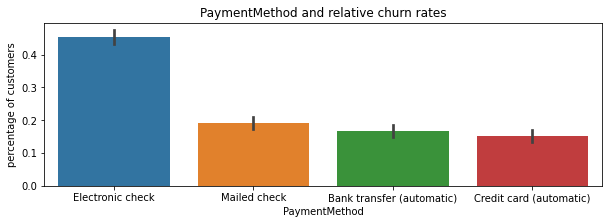

In [82]:
quater_feature = [x for x in data.columns[data.nunique() == 4]]
fig,axis = plt.subplots(figsize=(10,3))
ax = sns.barplot(data[quater_feature[0]],data['Churn'])
ax.set_ylabel('percentage of customers')
ax.set_title("{} and relative churn rates".format(quater_feature[0]))

In [83]:
# 计算每个属性之间的相关度
corr = data.drop(columns = ['customerID']).corr()
corr

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.016567,0.220173,0.103006,0.150889
tenure,0.016567,1.000000,0.247900,0.826178,-0.352229
MonthlyCharges,0.220173,0.247900,1.000000,0.651174,0.193356
TotalCharges,0.103006,0.826178,0.651174,1.000000,-0.198324
Churn,0.150889,-0.352229,0.193356,-0.198324,1.000000


In [84]:
mask  = np.zeros_like(corr,dtype=np.bool)
mask

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

In [85]:
mask[np.triu_indices_from(mask)] = True

In [86]:
mask

array([[ True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False,  True]])

<AxesSubplot:>

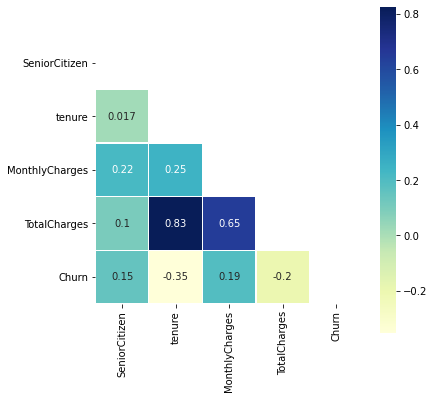

In [87]:
sns.heatmap(corr, xticklabels=corr.columns,mask=mask, yticklabels=corr.columns, square=True,
                  linewidths=.2, cmap="YlGnBu",annot=True)

### 数据编码
离散数据编码分为两种情况：
1. 离散特征的取值之间没有大小意义，使用one-hot编码
2. 离散特征的取值有大小意义，使用数值映射

In [88]:
charges = data.iloc[:,1:20]
charges.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


### pandas常见的编码方式
pd.get_dummies()：将字符型或者其他类型数据转换成一串数字向量，也就是所谓的one-hot编
pd.factorize():字符串映射成的数字的规则是先看见的小，后看见的大

In [89]:
corrDf = charges.apply(lambda x : pd.factorize(x)[0])
corrDf.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,1,1,0,1,1,1,0,0,0,1,1,1,1,1
2,1,0,1,0,2,1,1,0,1,0,0,0,0,0,0,0,1,2,2
3,1,0,1,0,3,0,0,0,1,1,1,1,0,0,1,1,2,3,3
4,0,0,1,0,2,1,1,1,0,1,0,0,0,0,0,0,0,4,4


### 相关性分析

In [90]:
corr = corrDf.corr()
corr

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
gender,1.000000,-0.001874,0.001808,0.010517,-0.000013,-0.006488,-0.009451,-0.000863,-0.003429,0.012230,0.005092,0.000985,0.001156,-0.000191,0.000126,0.011754,-0.005209,-0.008072,-0.012302
SeniorCitizen,-0.001874,1.000000,-0.016479,-0.211185,0.010834,0.008576,0.113791,-0.032310,-0.210897,-0.144828,-0.157095,-0.223770,-0.130130,-0.120802,-0.142554,-0.156530,-0.093704,0.049649,0.023880
Partner,0.001808,-0.016479,1.000000,-0.452676,-0.101985,-0.017706,-0.117307,-0.000891,-0.081850,0.090753,-0.094451,-0.069072,-0.080127,-0.075779,-0.294806,-0.014877,-0.133115,-0.036054,-0.042628
Dependents,0.010517,-0.211185,-0.452676,1.000000,0.048514,-0.001762,-0.019657,0.044590,0.190523,0.062775,0.156439,0.180832,0.140395,0.125820,0.243187,0.111377,0.123844,-0.029390,0.006300
tenure,-0.000013,0.010834,-0.101985,0.048514,1.000000,-0.018799,0.063510,-0.012008,0.017083,-0.064613,0.037174,0.033108,0.027090,0.031491,0.122446,-0.011129,0.075379,0.041647,0.108142
PhoneService,-0.006488,0.008576,-0.017706,-0.001762,-0.018799,1.000000,0.675070,0.387436,0.125353,0.129770,0.138755,0.123350,0.171538,0.165205,0.002247,-0.016505,-0.004070,-0.141829,-0.029806
MultipleLines,-0.009451,0.113791,-0.117307,-0.019657,0.063510,0.675070,1.000000,0.186826,-0.066844,-0.130619,-0.013069,-0.066684,0.030195,0.028187,0.083343,-0.133255,0.025676,0.024338,0.015373
InternetService,-0.000863,-0.032310,-0.000891,0.044590,-0.012008,0.387436,0.186826,1.000000,0.607788,0.650962,0.662957,0.609795,0.712890,0.709020,0.099721,0.138625,0.008124,-0.289963,-0.038247
OnlineSecurity,-0.003429,-0.210897,-0.081850,0.190523,0.017083,0.125353,-0.066844,0.607788,1.000000,0.621739,0.749040,0.791225,0.701976,0.704984,0.389978,0.334003,0.213800,-0.220566,-0.026788
OnlineBackup,0.012230,-0.144828,0.090753,0.062775,-0.064613,0.129770,-0.130619,0.650962,0.621739,1.000000,0.601503,0.617003,0.604117,0.606863,0.035407,0.260715,0.003183,-0.284344,-0.054537


Text(0.5, 1.0, 'Correlation between variables')

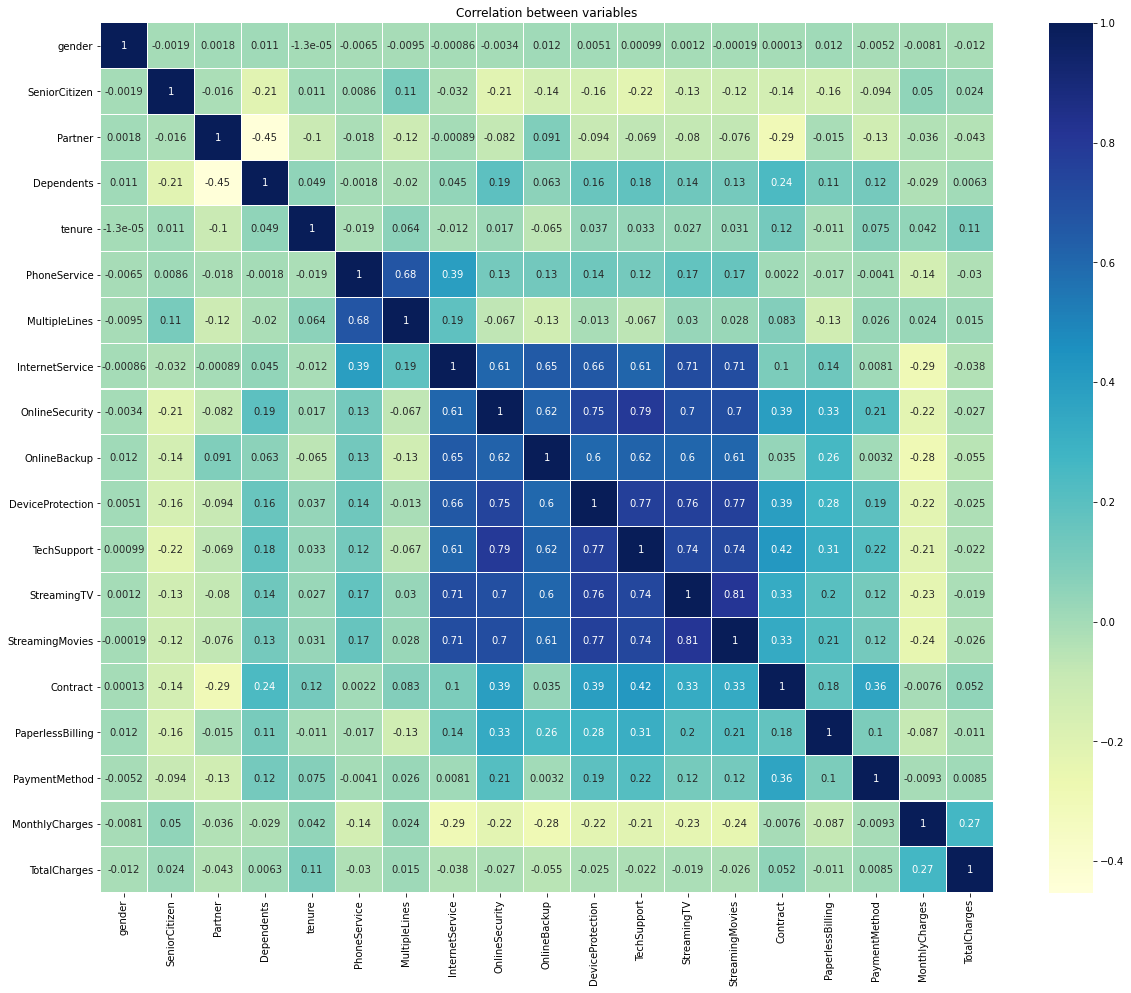

In [93]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=0.2,cmap="YlGnBu",annot=True)
plt.title('Correlation between variables')

In [95]:
# 使用one-hot编码
tel_dummies = pd.get_dummies(data.iloc[:,1:21])
tel_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [97]:
data.shape

(7043, 22)

Text(0.5, 1.0, 'Correlations between Churn and variables')

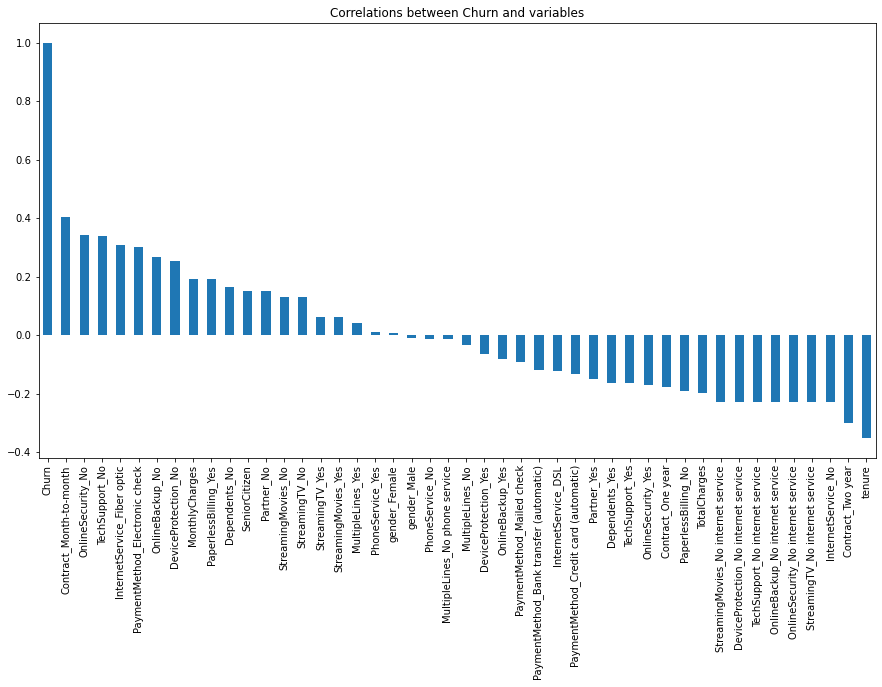

In [98]:
# 流失用户与各变量之间的相关性
plt.figure(figsize=(15,8))
tel_dummies.corr()['Churn'].sort_values(ascending=False).plot(kind='bar')
plt.title('Correlations between Churn and variables')

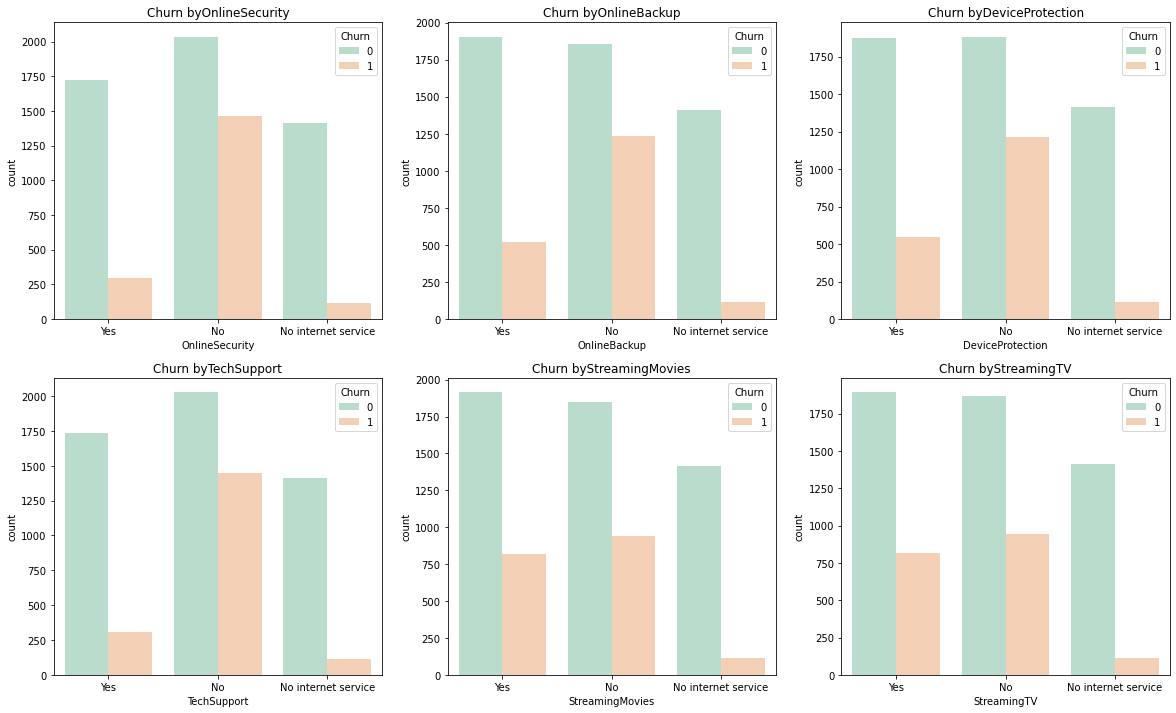

In [102]:
# 网络安全服务、在线备份业务、设备保护业务、技术支持服务、网络电视、网络电影和无互联网服务对客户流失率的影响
covariables = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingMovies','StreamingTV']
fig,axes = plt.subplots(nrows = 2,ncols = 3,figsize=(20,12))
for i,item in enumerate(covariables):
    plt.subplot(2,3,(i+1))
    ax = sns.countplot(x=item,hue='Churn',data=data,palette='Pastel2',order = ['Yes','No','No internet service'])
    plt.xlabel(str(item))
    plt.title('Churn by' + str(item))
    i = i + 1
plt.show()

在网络安全服务、在线备份业务、设备保护业务、技术支持服务、网络电视和网络电影六个变量中，没有互联网服务的客户流失率值是相同的，都是相对较低。
这可能是因为以上六个因素只有在客户使用互联网服务时才会影响客户的决策，这六个因素不会对不使用互联网服务的客户决定是否流失产生推论效应

In [111]:
data['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

Text(0.5, 1.0, 'Churn by Contract type')

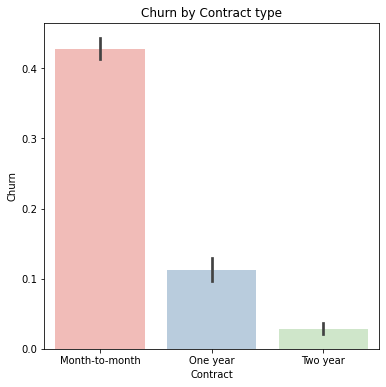

In [112]:
# 合同方式都客户流失率的影响
sns.barplot(x = 'Contract',y = 'Churn',data = data,palette = 'Pastel1',order= ['Month-to-month', 'One year', 'Two year'])
plt.title('Churn by Contract type')

In [114]:
data['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Text(0.5, 1.0, 'Churn by PaymentMethod type')

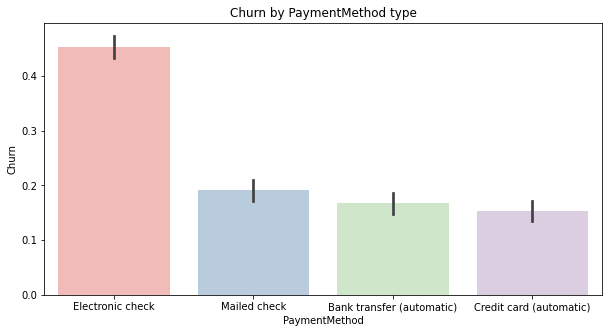

In [123]:
# 付款方式对客户流失率的影响
plt.figure(figsize=(10,5))
sns.barplot(x = 'PaymentMethod',y = 'Churn',data = data,palette = 'Pastel1',
            order = ['Electronic check', 'Mailed check', 'Bank transfer (automatic)','Credit card (automatic)'])
plt.title('Churn by PaymentMethod type')

### 数据预处理

In [124]:
# 删除不重要的列：customerID，gender和phoneService
data_var = data.iloc[:,2:20]
data_var.drop('PhoneService',axis=1,inplace=True)
data_var.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [126]:
# 对Tenure、MonthlyCharges、TotalCharges进行标准化
scaler = StandardScaler(copy = False)
# fit_transform()先拟合数据，然后再转化成标准数据
scaler.fit_transform(data[['tenure','MonthlyCharges','TotalCharges']])

array([[-1.27744458, -1.16032292, -0.99261052],
       [ 0.06632742, -0.25962894, -0.17216471],
       [-1.23672422, -0.36266036, -0.9580659 ],
       ...,
       [-0.87024095, -1.1686319 , -0.85293201],
       [-1.15528349,  0.32033821, -0.87051315],
       [ 1.36937906,  1.35896134,  2.01389665]])

In [128]:
data[['tenure','MonthlyCharges','TotalCharges']] = scaler.transform(data[['tenure','MonthlyCharges','TotalCharges']])

Text(0.5, 1.0, 'Check outliers of standardized tenure, MonthlyCharges and TotalCharges')

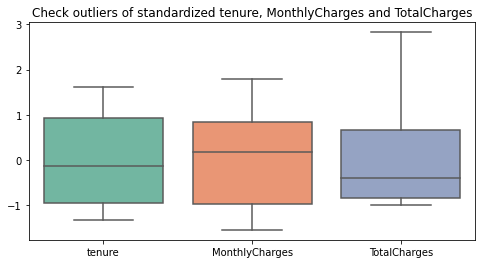

In [129]:
# 使用箱体图查看数据是否存在异常值
plt.figure(figsize=(8,4))
numbox = sns.boxplot(data=data[['tenure','MonthlyCharges','TotalCharges']],palette='Set2')
plt.title("Check outliers of standardized tenure, MonthlyCharges and TotalCharges")

In [135]:
# 查看object类型字段中存在的值
def uni(columnable):
    print(columnable,'---',data_var[columnable].unique())

data_obj = data_var.select_dtypes(['object'])
for i in range(0,len(data_obj.columns)):
    uni(data_obj.columns[i])

Partner --- ['Yes' 'No']
Dependents --- ['No' 'Yes']
MultipleLines --- ['No' 'Yes']
InternetService --- ['DSL' 'Fiber optic' 'No']
OnlineSecurity --- ['No' 'Yes']
OnlineBackup --- ['Yes' 'No']
DeviceProtection --- ['No' 'Yes']
TechSupport --- ['No' 'Yes']
StreamingTV --- ['No' 'Yes']
StreamingMovies --- ['No' 'Yes']
Contract --- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling --- ['Yes' 'No']
PaymentMethod --- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [136]:
# 替换值:使用 No 替代 No internet service
data_var.replace(to_replace='No internet service',value='No',inplace=True)
data_var.replace(to_replace='No phone service',value='No',inplace=True)
for i in range(0,len(data_obj.columns)):
    uni(data_obj.columns[i])

Partner --- ['Yes' 'No']
Dependents --- ['No' 'Yes']
MultipleLines --- ['No' 'Yes']
InternetService --- ['DSL' 'Fiber optic' 'No']
OnlineSecurity --- ['No' 'Yes']
OnlineBackup --- ['Yes' 'No']
DeviceProtection --- ['No' 'Yes']
TechSupport --- ['No' 'Yes']
StreamingTV --- ['No' 'Yes']
StreamingMovies --- ['No' 'Yes']
Contract --- ['Month-to-month' 'One year' 'Two year']
PaperlessBilling --- ['Yes' 'No']
PaymentMethod --- ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [140]:
# 使用scikit_learn标签编码，将分类数据转化成整数编码
def labelencode(columnlabel):
    data_var[columnlabel] = LabelEncoder().fit_transform(data_var[columnlabel])

    
for i in range(0,len(data_var.columns)):
    labelencode(data_var.columns[i])
    
for i in range(0,len(data_obj.columns)):
    uni(data_obj.columns[i])

Partner --- [1 0]
Dependents --- [0 1]
MultipleLines --- [0 1]
InternetService --- [0 1 2]
OnlineSecurity --- [0 1]
OnlineBackup --- [1 0]
DeviceProtection --- [0 1]
TechSupport --- [0 1]
StreamingTV --- [0 1]
StreamingMovies --- [0 1]
Contract --- [0 1 2]
PaperlessBilling --- [1 0]
PaymentMethod --- [2 3 0 1]


### 构建模型

In [141]:
X=data_var
y=data["Churn"].values
'''
交叉验证函数StratifiedShuffleSplit，功能是从样本数据中随机按比例选取训练数据（train）和测试数据（test）
参数 n_splits是将训练数据分成train/test对的组数，可根据需要进行设置，默认为10
参数test_size和train_size是用来设置train/test对中train和test所占的比例
参数 random_state控制是将样本随机打乱
'''
sss=StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print(sss)
print("训练数据和测试数据被分成的组数：",sss.get_n_splits(X,y))

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)
训练数据和测试数据被分成的组数： 5


In [142]:
# 建立训练数据和测试数据
for train_index, test_index in sss.split(X, y):
    print("train:", train_index, "test:", test_index)
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y[train_index], y[test_index]

train: [2499 5807 5118 ...  525 5748 6513] test: [5532 5173 7010 ... 6920 4696 2246]
train: [4996 2890 5709 ... 1546 3245 2928] test: [2015  868 5117 ...  550 5489  802]
train: [1695 4494 5164 ... 5963 2685 6386] test: [3303 3669  953 ... 5927 3078  880]
train: [5764 6926 2748 ... 3510  496 2656] test: [2714 3165 3010 ... 3153 3923 6120]
train: [4898 3058 2085 ... 6143  981 5287] test: [3080 4416 6547 ... 2551 4873 1388]


In [143]:
# 输出数据集大小
print('原始数据特征：', X.shape,
      '训练数据特征：',X_train.shape,
      '测试数据特征：',X_test.shape)

print('原始数据标签：', y.shape,
      '   训练数据标签：',y_train.shape,
      '   测试数据标签：',y_test.shape)

原始数据特征： (7043, 17) 训练数据特征： (5634, 17) 测试数据特征： (1409, 17)
原始数据标签： (7043,)    训练数据标签： (5634,)    测试数据标签： (1409,)


In [147]:
# 使用分类算法，这里选用10种分类算法
Classifiers=[["Random Forest",RandomForestClassifier()],
             ["Support Vector Machine",SVC()],
             ["LogisticRegression",LogisticRegression()],
             ["KNN",KNeighborsClassifier(n_neighbors=5)],
             ["Naive Bayes",GaussianNB()],
             ["Decision Tree",DecisionTreeClassifier()],
             ["AdaBoostClassifier", AdaBoostClassifier()],
             ["GradientBoostingClassifier", GradientBoostingClassifier()],
             ["XGB", XGBClassifier(eval_metric='mlogloss')],
             ["CatBoost", CatBoostClassifier(logging_level='Silent')]  
]

In [156]:
Classify_result=[]
names=[]
prediction=[]
for name,classifier in Classifiers:
    classifier=classifier
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    recall=recall_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    f1score=f1_score(y_test,y_pred)
    class_eva=pd.DataFrame([recall,precision,f1score])
    Classify_result.append(class_eva)
    name=pd.Series(name)
    names.append(name)
    y_pred=pd.Series(y_pred)
    prediction.append(y_pred)

In [157]:
# 评估模型
names=pd.DataFrame(names)
names=names[0].tolist()
result=pd.concat(Classify_result,axis=1)
result.columns=names
result.index=["recall","precision","f1score"]
result

,Random Forest,Support Vector Machine,LogisticRegression,KNN,Naive Bayes,Decision Tree,AdaBoostClassifier,GradientBoostingClassifier,XGB,CatBoost
recall,0.529412,0.385027,0.577540,0.532086,0.770053,0.532086,0.582888,0.577540,0.558824,0.561497
precision,0.671186,0.734694,0.668731,0.619938,0.517986,0.492574,0.637427,0.658537,0.651090,0.662461
f1score,0.591928,0.505263,0.619799,0.572662,0.619355,0.511568,0.608939,0.615385,0.601439,0.607815


In [161]:
# 进行测试
pred_x = data_var.tail(10)
pred_id = data['customerID'].tail(10)

# 使用朴素贝叶斯方法，对预测数据进行预测
model = GaussianNB()
model.fit(X_train,y_train)
pred_y = model.predict(pred_x)

# 预测结果
predDf = pd.DataFrame({'customerID':pred_id, 'Churn':pred_y})
predDf

,customerID,Churn
7033,9767-FFLEM,1
7034,0639-TSIQW,0
7035,8456-QDAVC,1
7036,7750-EYXWZ,0
7037,2569-WGERO,0
7038,6840-RESVB,0
7039,2234-XADUH,0
7040,4801-JZAZL,0
7041,8361-LTMKD,1
7042,3186-AJIEK,0
